In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

from pandas import DataFrame
from initializer import init

%matplotlib inline
plt.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

init()

In [2]:
import utils

# 1. Moving Average 활용 전략

- `BUY`: whenever the shorter SMA start to be above the longer one
- `SELL`: whenever the shorter SMA start to be below the longer one

In [3]:
df: DataFrame = fdr.DataReader("005930", "2010-01-02", "2020-10-30")
df = df[["Close"]]
df.head()

,Close
Date,
2010-01-04,16180
2010-01-05,16440
2010-01-06,16820
2010-01-07,16260
2010-01-08,16420


In [4]:
BUSSINESS_DAY_IN_MONTH = 21

df["SMA_short"] = df["Close"].rolling(BUSSINESS_DAY_IN_MONTH * 6).mean()
df["SMA_long"] = df["Close"].rolling(BUSSINESS_DAY_IN_MONTH * 12).mean()
df = df.dropna()
df.head()

,Close,SMA_short,SMA_long
Date,,,
2011-01-03,19160,16152.063,16083.254
2011-01-04,19160,16181.111,16095.079
2011-01-05,18840,16208.571,16104.603
2011-01-06,18600,16233.175,16111.667
2011-01-07,18420,16253.016,16120.238


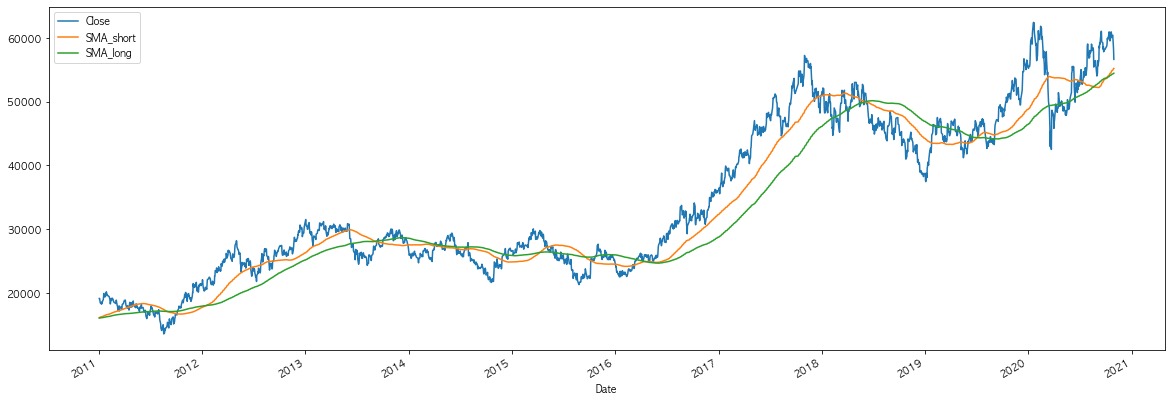

In [5]:
df.plot(figsize=(20, 7));

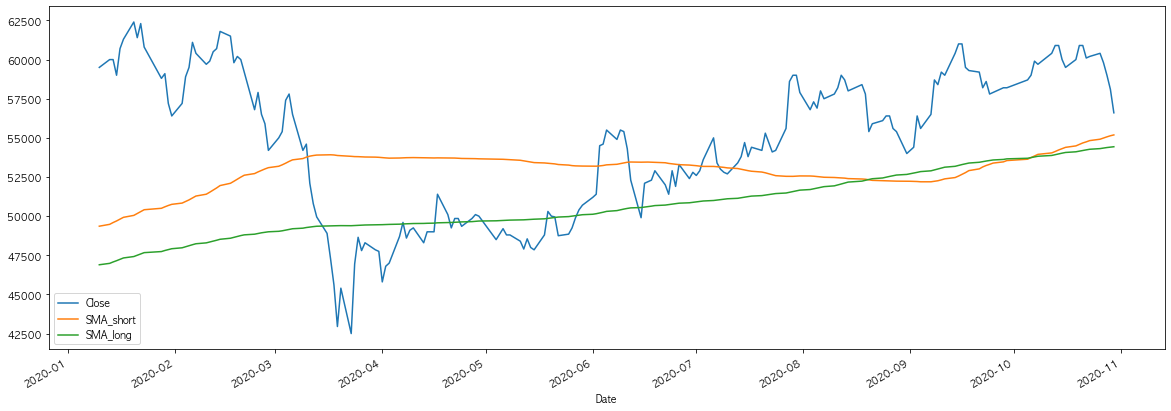

In [6]:
df.iloc[-200:].plot(figsize=(20, 7));

## 1.1. position 구하기

In [8]:
(df["SMA_short"] >= df["SMA_long"]).head()

Date
2011-01-03    True
2011-01-04    True
2011-01-05    True
2011-01-06    True
2011-01-07    True
dtype: bool

In [10]:
np.where(df["SMA_short"] >= df["SMA_long"], 1, 0)
np.where(df["SMA_short"] >= df["SMA_long"], 1, 0).mean()

array([1, 1, 1, ..., 1, 1, 1])

0.6187525815778604

In [12]:
df.loc[:, "position"] = np.where(df["SMA_short"] >= df["SMA_long"], 1, 0)
df["position"].head()

Date
2011-01-03    1
2011-01-04    1
2011-01-05    1
2011-01-06    1
2011-01-07    1
Name: position, dtype: int64

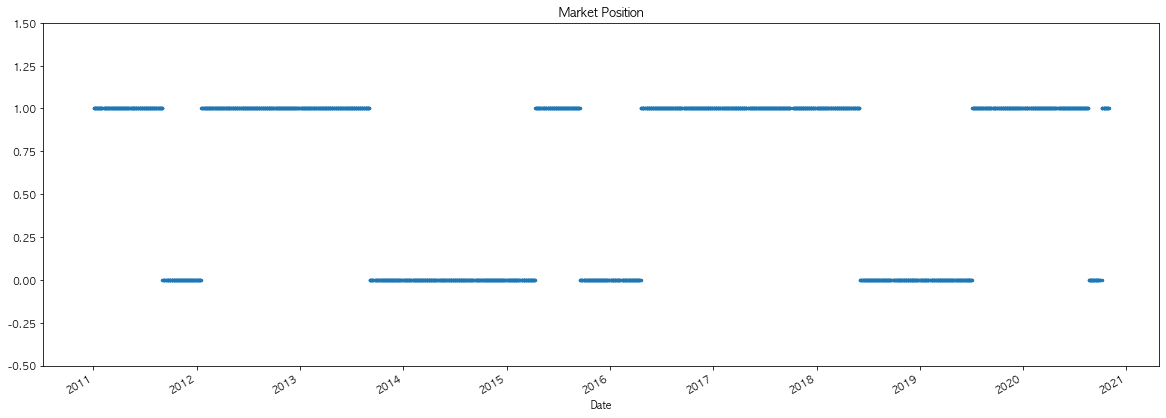

In [16]:
df["position"].plot(
    ylim=[-0.5, 1.5], title="Market Position", figsize=(20, 7), marker=".", markersize=5, linestyle="none"
);

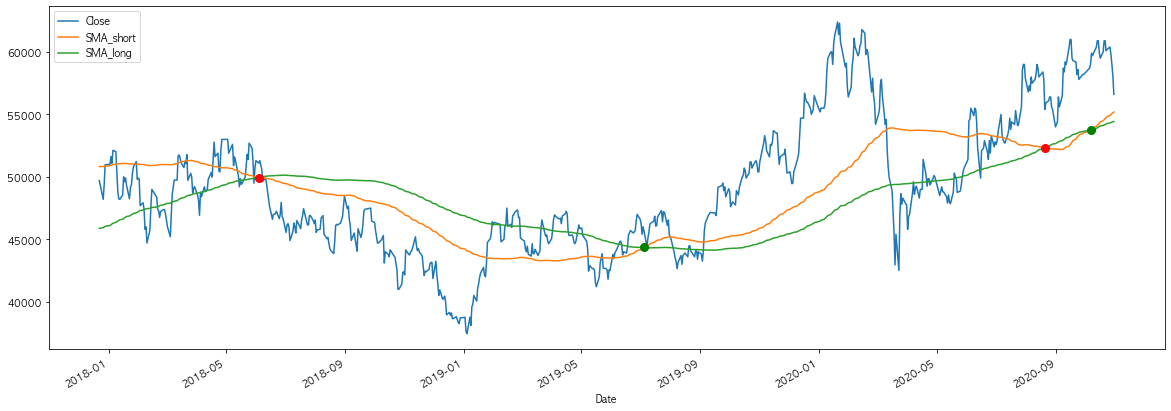

In [21]:
_df = df.iloc[-700:]

exit_index = _df.loc[(_df["position"] - _df["position"].shift()) == -1].index
long_index = _df.loc[(_df["position"] - _df["position"].shift()) == 1].index

ax = _df.drop(["position"], axis=1).plot(figsize=(20, 7))
_df.loc[exit_index, "SMA_short"].plot(ax=ax, marker="o", markersize=8, linestyle="none", color="red")
_df.loc[long_index, "SMA_short"].plot(ax=ax, marker="o", markersize=8, linestyle="none", color="green");

## 1.2. Return 구하기

In [22]:
df.loc[:, "rtn"] = utils.get_returns_df(df["Close"], log=True)

```python
why_are_we = (df["position"].shift(1) * df["rtn"]).fillna(0)
```

- 왜 `shift(1)`을 하는가?
  - 해당 일에 position은 당일 종가를 받아서 이미 moving average 등 모든 계산이 끝난 후에 결정되는 position이다.
  - 따라서 오늘 position을 1로 설정했으면 (다음날 얻는 수익 * 1) 만큼 수익이 발생한다.

> 종가로 positioning을 했으니까 종가에 딱 사면 장이 끝난 거고, 즉 매수 당일에는 수익률이 있다고 볼 수 없다.  
> 그래서 position을 shift 처리 후에 다음 날 수익률으로 표시하는 것이 옳다.

In [23]:
df.loc[:, "strategy_rtn"] = (df["position"].shift(1) * df["rtn"]).fillna(0)

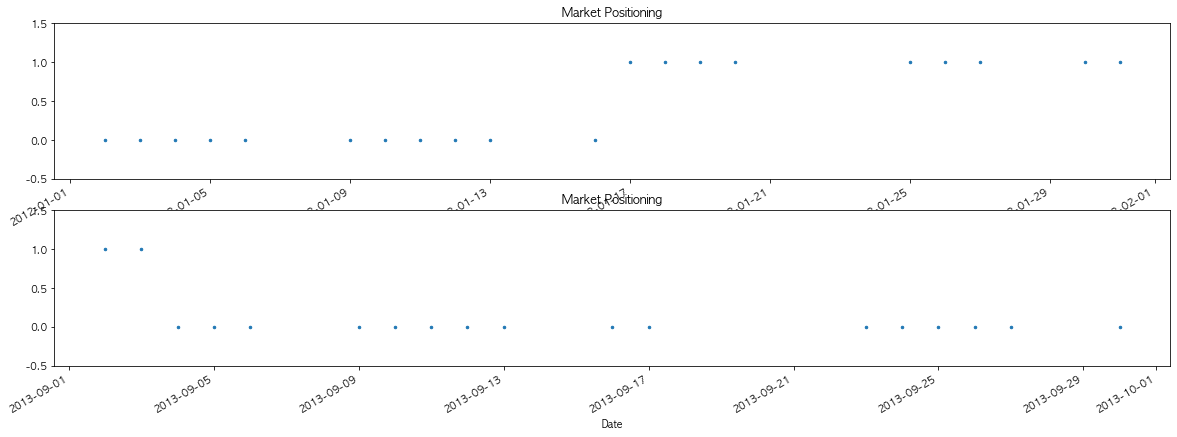

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))
df["position"].loc["2012-01"].plot(
    ax=axes[0],
    ylim=[-0.5, 1.5], title="Market Positioning", figsize=(20, 7), marker=".", markersize="5", linestyle="none"
)
df["position"].loc["2013-09"].plot(
    ax=axes[1],
    ylim=[-0.5, 1.5], title="Market Positioning", figsize=(20, 7), marker=".", markersize="5", linestyle="none"
);

In [30]:
df.loc[:, "cum_rtn"] = utils.get_cum_returns_df(df["rtn"], log=True)
df.loc[:, "cum_strategy_rtn"] = utils.get_cum_returns_df(df["strategy_rtn"], log=True)
df.head()

,Close,SMA_short,SMA_long,position,rtn,strategy_rtn,cum_rtn,cum_strategy_rtn
Date,,,,,,,,
2011-01-03,19160,16152.063,16083.254,1,0.000,0.000,1.000,1.000
2011-01-04,19160,16181.111,16095.079,1,0.000,0.000,1.000,1.000
2011-01-05,18840,16208.571,16104.603,1,-0.017,-0.017,0.983,0.983
2011-01-06,18600,16233.175,16111.667,1,-0.013,-0.013,0.971,0.971
2011-01-07,18420,16253.016,16120.238,1,-0.010,-0.010,0.961,0.961


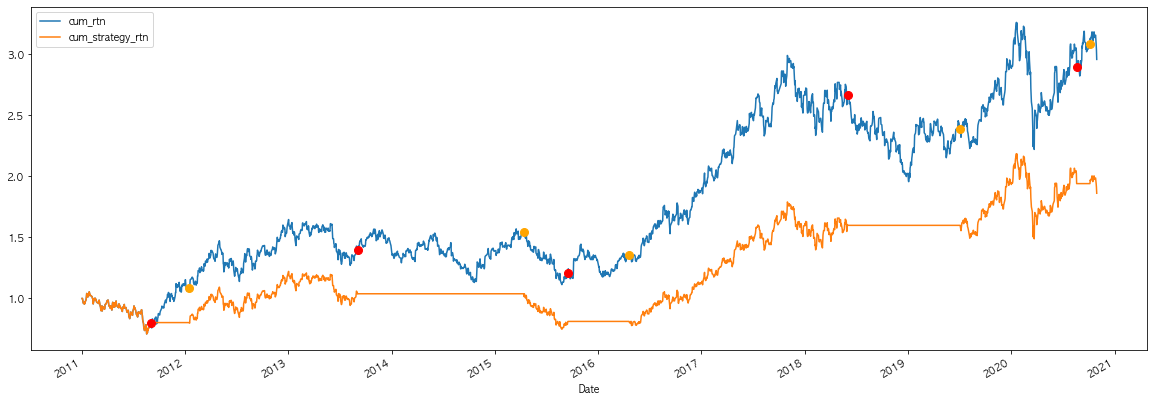

In [32]:
exit_index = df[(df['position'] - df['position'].shift()) == -1].index
long_index = df[(df['position'] - df['position'].shift()) == 1].index

ax = df[['cum_rtn', 'cum_strategy_rtn']].plot(figsize=(20, 7))
df.loc[exit_index, "cum_rtn"].plot(ax=ax, marker="o", markersize=8, linestyle="none", color="red")
df.loc[long_index, "cum_rtn"].plot(ax=ax, marker="o", markersize=8, linestyle="none", color="orange");

## 1.3. Performance 구하기

In [34]:
utils.get_sharpe_ratio(df[["rtn", "strategy_rtn"]]).to_frame("Sharpe Ratio")

,Sharpe Ratio
rtn,0.318
strategy_rtn,0.176


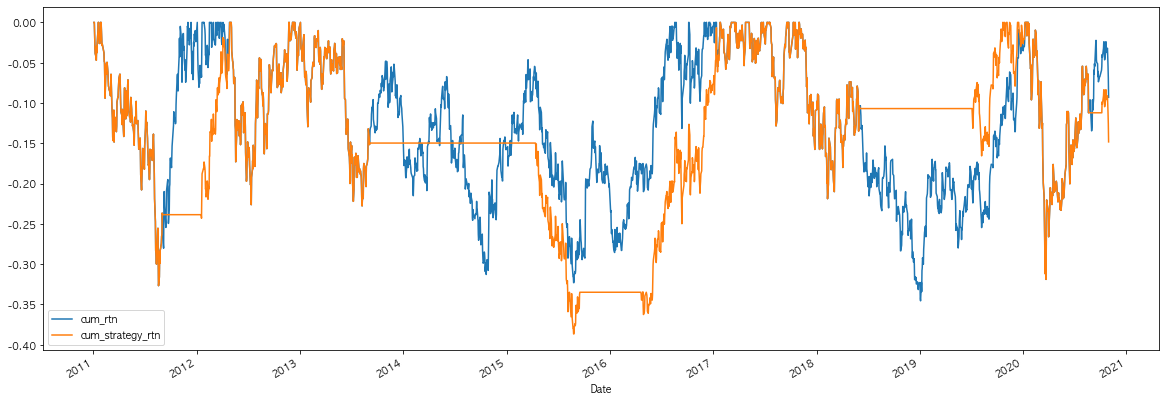

In [35]:
infos = utils.get_drawdown_infos(df.filter(like="cum_"))
infos[0].plot(figsize=(20, 7));

In [36]:
mdd_series = infos[1]
mdd_series.to_frame("MDD")

,MDD
cum_rtn,-0.346
cum_strategy_rtn,-0.387


In [38]:
longest_dd_period_df = infos[2]
longest_dd_period_df

,drawdown mean,drawdown std,longest days,longest period
cum_rtn,36,158,1324,2013-01-02 ~ 2016-08-18
cum_strategy_rtn,49,200,1484,2013-01-02 ~ 2017-01-25
